In [206]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Introduction

In this competition, we are asked  to use reservation and visitation data to predict the total number of visitors to a restaurant for future dates. This information is supposed to help restaurants be much more efficient and allow them to focus on creating an enjoyable dining experience for their customers. 

This is a nice opportunity to learn more about Japan!!!

The data comes from two separate sites:

* Hot Pepper Gourmet (hpg): similar to Yelp, here users can search restaurants and also make a reservation online
* AirREGI / Restaurant Board (air): similar to Square, a reservation control and cash register system

In [207]:
#
import numpy as np
import pandas as pd
from subprocess import check_output
import matplotlib.pyplot as plt
import seaborn as sns

## Data Wrangling

The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week."

In [208]:
ls *.csv

air_reserve.csv        hpg_reserve.csv        sub_geo_mean_1.csv
air_store_info.csv     hpg_store_info.csv     sub_hrm_mean_1.csv
air_visit_data.csv     sample_submission.csv  sub_math_mean_1.csv
date_info.csv          store_id_relation.csv


In [209]:
#
airres = pd.read_csv('air_reserve.csv')
airstore = pd.read_csv('air_store_info.csv')
hpgres = pd.read_csv('hpg_reserve.csv')
hpgstore = pd.read_csv('hpg_store_info.csv')
airvisit = pd.read_csv('air_visit_data.csv')

In [210]:
#
airvisit.tail()

,air_store_id,visit_date,visitors
252103,air_24e8414b9b07decb,2017-04-18,6
252104,air_24e8414b9b07decb,2017-04-19,6
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


In [211]:
#
airres.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [212]:
pd.set_option('display.max_rows', 6)

In [213]:
airres

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
...,...,...,...,...
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10
92377,air_3cad29d1a23209d2,2017-05-31 21:00:00,2017-04-22 10:00:00,3


In [214]:
airres.air_store_id.value_counts()

air_8093d0b565e9dbdf    2263
air_e55abd740f93ecc4    1903
air_0a74a5408a0b8642    1831
                        ... 
air_cf2229e64408d9fe       1
air_96005f79124e12bf       1
air_883ca28ef0ed3d55       1
Name: air_store_id, Length: 314, dtype: int64

In [215]:
airstore

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
...,...,...,...,...,...
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956
828,air_c8fe396d6c46275d,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [216]:
airstore.air_store_id.value_counts()

air_e89735e80d614a7e    1
air_bed603c423b7d9d4    1
air_c77ee2b7d36da265    1
                       ..
air_ea6d0c3acf00b22a    1
air_96005f79124e12bf    1
air_daa7947e1c47f5ed    1
Name: air_store_id, Length: 829, dtype: int64

In [217]:
air = pd.merge(airres, airstore, on='air_store_id')
air

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...,...,...,...
92375,air_b3a824511477a4ed,2017-05-21 19:00:00,2017-04-20 19:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
92376,air_cf2229e64408d9fe,2017-04-20 23:00:00,2017-04-20 10:00:00,2,Dining bar,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025
92377,air_e700e390226d9985,2017-05-23 19:00:00,2017-04-14 16:00:00,11,Izakaya,Miyagi-ken Sendai-shi Kamisugi,38.269076,140.870403


In [218]:
air.isnull().sum().any()

False

In [219]:
air.air_store_id.value_counts()

air_8093d0b565e9dbdf    2263
air_e55abd740f93ecc4    1903
air_0a74a5408a0b8642    1831
                        ... 
air_cf2229e64408d9fe       1
air_96005f79124e12bf       1
air_883ca28ef0ed3d55       1
Name: air_store_id, Length: 314, dtype: int64

In [220]:
hpgres

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
...,...,...,...,...
2000317,hpg_e9151de687b93aa3,2017-05-31 21:00:00,2017-04-14 20:00:00,49
2000318,hpg_fae6c96189b4a122,2017-05-31 21:00:00,2017-04-19 17:00:00,9
2000319,hpg_0b70de808b55ad1e,2017-05-31 23:00:00,2017-04-21 13:00:00,6


In [221]:
hpgstore

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
...,...,...,...,...,...
4687,hpg_d2021704076cdd70,Shanghai food,Tōkyō-to Chiyoda-ku None,35.695780,139.768453
4688,hpg_602472570d65e219,Spain/Mediterranean cuisine,Tōkyō-to Toshima-ku None,35.730068,139.711742
4689,hpg_11801306ce8bfb4f,Udon/Soba,Osaka Prefecture Osaka None,34.701519,135.498859


In [222]:
air

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
...,...,...,...,...,...,...,...,...
92375,air_b3a824511477a4ed,2017-05-21 19:00:00,2017-04-20 19:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
92376,air_cf2229e64408d9fe,2017-04-20 23:00:00,2017-04-20 10:00:00,2,Dining bar,Ōsaka-fu Ōsaka-shi Ōgimachi,34.705362,135.510025
92377,air_e700e390226d9985,2017-05-23 19:00:00,2017-04-14 16:00:00,11,Izakaya,Miyagi-ken Sendai-shi Kamisugi,38.269076,140.870403


In [224]:
#
air = pd.merge(airres, airstore, on='air_store_id') # airres　に genre, area position　などを追加
hpg = pd.merge(hpgres, hpgstore, on='hpg_store_id') # 上と同様
rel = pd.read_csv('store_id_relation.csv') # air_store_id と hpg_store_id　の2つ（対応を示している）
airrel = pd.merge(air, rel, how='left',on='air_store_id') # 314個中 150個　対応がありそう
hpgrel = pd.merge(hpg, rel, how='left',on='hpg_store_id')
full = pd.merge(airrel, hpgrel, how='outer')
print("there are ",len(air)," restaurants with AIR and ",len(hpg)," with HPG.",len(rel),' have both.')

there are  92378  restaurants with AIR and  871308  with HPG. 150  have both.


## A Bit of Geography and Clustering

Apparently Japan's terittory is divided in 8 regions which are not official administrative units, but have been traditionally used as the regional division of Japan in a number of contexts [https://en.wikipedia.org/wiki/List_of_regions_of_Japan ]

From north to south, the traditional regions are:
* **Hokkaidō** (the island of Hokkaidō and nearby islands, population: 5,507,456, largest city: Sapporo)
* **Tōhoku** region (northern Honshū, population: 9,335,088, largest city: Sendai)
* **Kantō** region (eastern Honshū, population: 42,607,376, largest city: Tokyo)
* **Chūbu region** (central Honshū, including Mt. Fuji, population: 21,714,995, largest city: Nagoya), sometimes divided into:
   * Hokuriku region (northwestern Chūbu, largest city: Kanazawa)
   * Kōshin'etsu region (northeastern Chūbu, largest city: Niigata)
  * Tōkai region (southern Chūbu, largest city: Nagoya)
* **Kansai or Kinki** region (west-central Honshū, including the old capital, Kyoto, population: 22,755,030, largest city: Osaka)
* **Chūgoku** region (western Honshū, population: 7,561,899, largest city: Hiroshima)
* **Shikoku** (island, population: 3,977,205, largest city: Matsuyama)
* **Kyūshū** (island, population: 14,596,977, largest city: Fukuoka) which includes:
  * Northern Kyushu: Fukuoka, Saga, Nagasaki and Ōita (largest city: Fukuoka)
  * Southern Kyushu: Kumamoto, Miyazaki and Kagoshima (largest city: Kagoshima)
  * Okinawa (largest city: Naha)

![](http://goinjapanesque.com/wpos/wp-content/uploads/2015/07/Japan-map-en.png)

I am now going to identify 10 clusters with KMeans according to the restaurants' coordinates. Markers of different clusters will be depicted with different colors. I will place a black dot representing the cluster centroid with a label identifying it as an integer. I will also place a label close to the cluster with the name of the Japan region in which that cluster relies.

In [225]:
full

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
963683,NaN,2017-04-24 19:00:00,2017-04-22 14:00:00,15,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None
963684,NaN,2017-04-24 19:00:00,2017-04-10 17:00:00,18,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None
963685,NaN,2017-04-28 18:00:00,2017-04-10 17:00:00,22,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None


In [226]:
#
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=0).fit(full[['longitude','latitude']])
full['cluster'] = kmeans.predict(full[['longitude','latitude']])

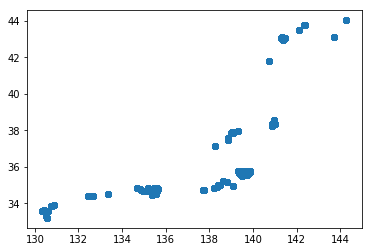

In [227]:
import matplotlib.pyplot as plt
plt.scatter(full.longitude, full.latitude)

In [228]:
full['cluster'].value_counts()

0    402108
1    136345
3     96026
      ...  
4     36354
7     34913
8     16092
Name: cluster, Length: 10, dtype: int64

![](japanese-map.png)

Let's try to relate the identified groups with the biggest cities:

* Cluster 0 refers to Tokyo.
* Cluster 1 refers  to Osaka
* Cluster 2 refers to Sapporo
* Cluster 3 refers to Fukuoka
* Cluster 4 refers to Niigata
* Cluster 5 referst to Hiroshima
* Cluster 6 refers to Shizouku
* Cluster 7 refers to Sendai
* Cluster 9 refers to Kobe

In [229]:
import matplotlib.pyplot as plt

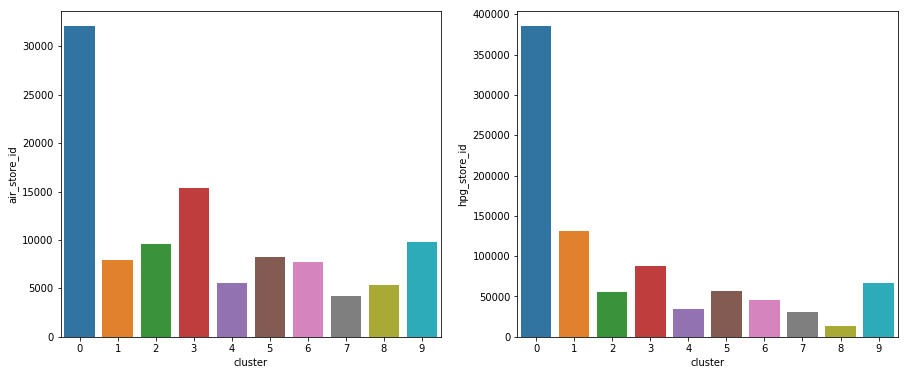

In [230]:
f,axa = plt.subplots(1,2,figsize=(15,6))
hist_clust = full.groupby(['cluster'], as_index=False).count()
sns.barplot(x=hist_clust.cluster, y=hist_clust.air_store_id, ax=axa[0])
sns.barplot(x=hist_clust.cluster, y=hist_clust.hpg_store_id, ax=axa[1])
plt.show()

let's see now how data is distributed

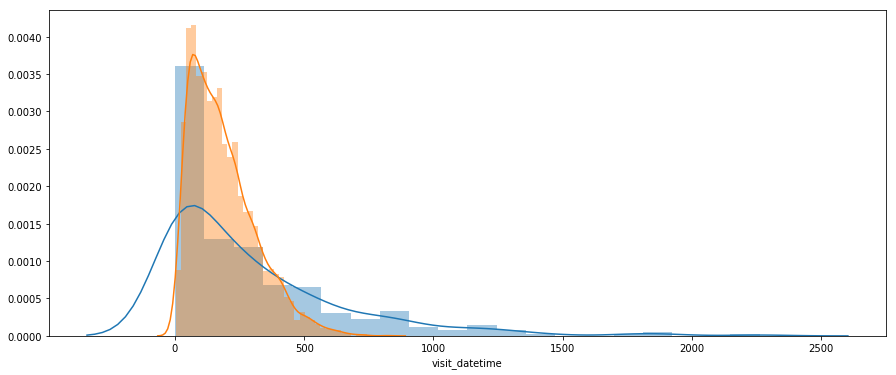

In [231]:
#
f,ax = plt.subplots(1,1,figsize=(15,6))
airhist = air.groupby(['air_store_id'], as_index=False).count() # 青
sns.distplot(airhist.visit_datetime)
hpghist = hpg.groupby(['hpg_store_id'], as_index=False).count() #　オレンジ
sns.distplot(hpghist.visit_datetime)
plt.show()
#sns.barplot(x= airhist.air_store_id,y = airhist.visit_datetime)

## Cousine Genres

Now let's check out wht are the genres appreciated in Japan. I have prepared two heatmaps: the former with thenumber of restaurants for each genre (columns) in each region (row) for thos with AIR reservation  system; the latter with the HPG.

For  the AIR restaurants, It looks like Izakayas, which I learned is a casual place for after-work drinking (like a pub?) https://en.wikipedia.org/wiki/Izakaya,  are the places with the wider appreciation, among regions. 

Italian and French Restaurants are instead the most appreciated in Tokyo, among the restaurants with the AIR system, which makes me happy since I am Italian :).


In [232]:
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns 

In [233]:
missing_values_table(full).T

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster
Missing Values,857780.000000,0.0,0.0,0.0,871308.000000,871308.000000,0.0,0.0,56114.000000,92378.000000,92378.000000,0.0
% of Total Values,89.010321,0.0,0.0,0.0,90.414098,90.414098,0.0,0.0,5.822851,9.585902,9.585902,0.0


In [234]:
#
air_genre = full.loc[full.air_genre_name.isnull() == False].groupby(
    ['cluster','air_genre_name'], as_index=False).count()
hpg_genre = full.loc[full.hpg_genre_name.isnull() == False].groupby(
    ['cluster','hpg_genre_name'], as_index=False).count()

In [235]:
print(air_genre.shape) # air_genre_name =14, cluster = 10
air_genre

(65, 12)


,cluster,air_genre_name,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name
0,0,Asian,2,2,2,2,2,2,2,0,0,0
1,0,Bar/Cocktail,189,189,189,189,189,189,189,10,0,0
2,0,Cafe/Sweets,809,809,809,809,809,809,809,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
62,9,Japanese food,604,604,604,604,604,604,604,604,0,0
63,9,Okonomiyaki/Monja/Teppanyaki,117,117,117,117,117,117,117,0,0,0
64,9,Yakiniku/Korean food,368,368,368,368,368,368,368,368,0,0


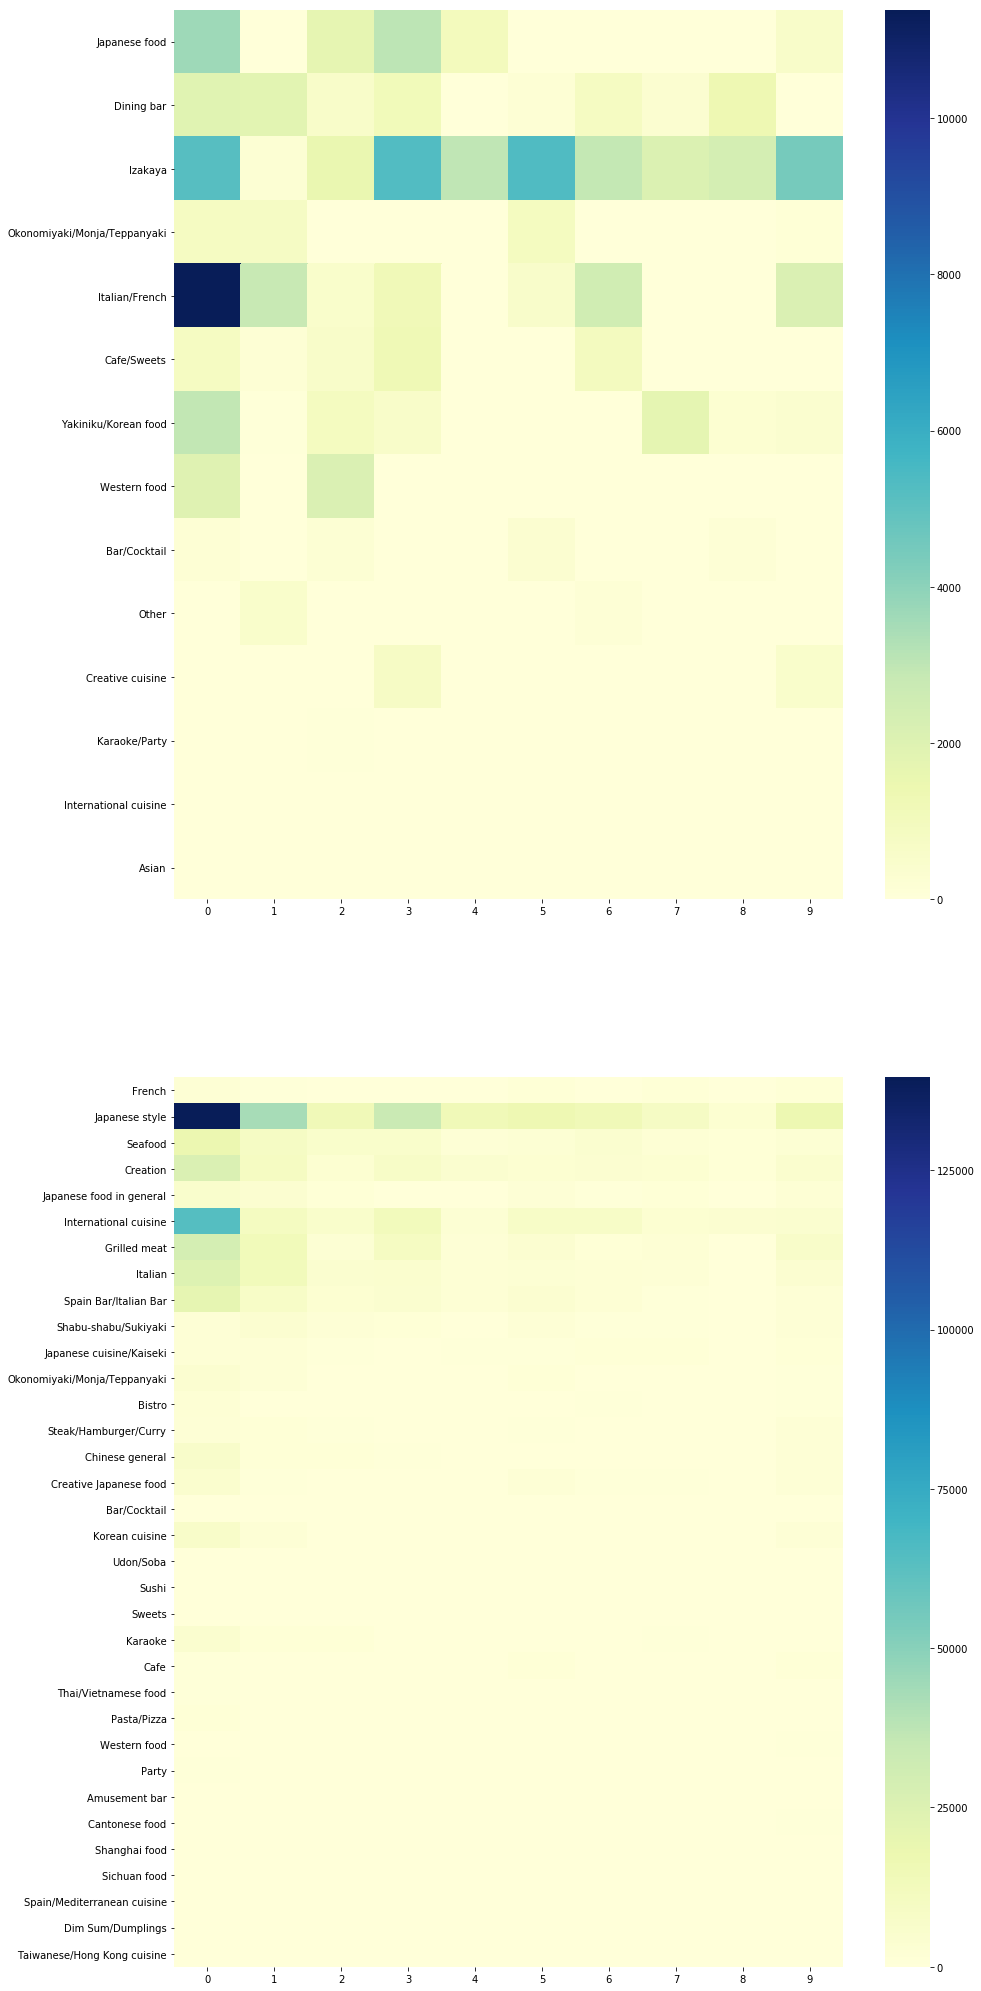

In [236]:
#
genres = air.air_genre_name.unique()
f,axa= plt.subplots(2,1,figsize=(15,36))
hm = []
for i in range(10):
    genres_count = [air_genre.loc[air_genre.cluster==i].loc[air_genre.air_genre_name==name]
                    ['air_store_id'].values[0] 
                    if name in air_genre.loc[air_genre.cluster==i].air_genre_name.values 
                    else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm, columns=genres,)
sns.heatmap(hm.transpose(), cmap="YlGnBu", ax=axa[0])

genres = hpg.hpg_genre_name.unique()
hm = []
for i in range(10):
    genres_count = [hpg_genre.loc[hpg_genre.cluster==i].loc[hpg_genre.hpg_genre_name==name]
                    ['hpg_store_id'].values[0] 
                    if name in hpg_genre.loc[hpg_genre.cluster==i].hpg_genre_name.values 
                    else 0 for name in genres] 
    hm.append(genres_count)
hm = pd.DataFrame(hm,columns=genres,)
sns.heatmap(hm.transpose(),cmap="YlGnBu",ax=axa[1])


plt.show()

## Japanese Holidays

Let's check what are the Japanese holidays excluding Saturday and Sundays

In [237]:
#
dates = pd.read_csv('date_info.csv')
dates.loc[dates.holiday_flg==1].loc[(dates.day_of_week != 'Saturday')].loc[dates.day_of_week 
                                                                          != 'Sunday']
# 土日以外の祝日を表示

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
10,2016-01-11,Monday,1
41,2016-02-11,Thursday,1
...,...,...,...
488,2017-05-03,Wednesday,1
489,2017-05-04,Thursday,1
490,2017-05-05,Friday,1


I want to learn more about that so I will rely on this list https://www.officeholidays.com/countries/japan/index.php

* Jan 1st - **New Years day **;
* 2nd Monday of January - **Coming of Age day **: The day honors young Japanese who will reach the age of 20 at any point during the year. Twenty is the age of majority in Japan, and people who have reached this age gain the right to vote in elections as well as to drink;
* Feb 11th - **National Foundation day**:  a national holiday for Japanese people to remind themselves of the nation's founding and foster their love for the nation;
* March 20th or 21st- **Vernal Equinox day**: The day is intended to celebrate the love of nature and living things.In modern Japan, the day still maintains its older traditions as visiting family graves and holding family reunions is a common way of celebrating the equinox;
* April 29th - ** Showa day**: Showa Day honours the birthday of Emperor Hirohito, the reigning Emperor before, during, and after World War II (from 1926 - 1989);

continue...


Now I am going to create two features telling me whther the reservation or the visit occurred in a holiday (reservation_holiday and visit_holiday are the new columns).

In [238]:
#
vdt = pd.to_datetime(full.visit_datetime)
rdt = pd.to_datetime(full.reserve_datetime)
full['vd']=vdt.dt.date
full['vt']=vdt.dt.time
full['rd']=rdt.dt.date
full['rt']=rdt.dt.time

In [239]:
dates

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
...,...,...,...
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
516,2017-05-31,Wednesday,0


In [240]:
#
dts = pd.to_datetime(dates.calendar_date)
days = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday']
dates['calendar_date'] = pd.to_datetime(dates['calendar_date']).dt.date

In [241]:
#
dates['dy'] = dts.dt.dayofyear
dates['dw'] = [days.index(dw) for dw in dates.day_of_week]
#dts.dt.dayofweek　でもできるが、これはMondayが0になる
dates

,calendar_date,day_of_week,holiday_flg,dy,dw
0,2016-01-01,Friday,1,1,5
1,2016-01-02,Saturday,1,2,6
2,2016-01-03,Sunday,1,3,0
...,...,...,...,...,...
514,2017-05-29,Monday,0,149,1
515,2017-05-30,Tuesday,0,150,2
516,2017-05-31,Wednesday,0,151,3


In [242]:
#
nf = pd.merge(full, dates[['calendar_date', 'holiday_flg']], how='left', left_on='vd',
              right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg':'visit_holiday'}) # index を int64→object　へ。
nf = nf.drop(['calendar_date'],axis=1)

In [243]:
#
nf = pd.merge(nf, dates[['calendar_date','holiday_flg']], how = 'left', 
              left_on='rd', right_on='calendar_date')
nf = nf.rename(index = str, columns = {'holiday_flg': 'reservation_holiday'})
nf = nf.drop(['calendar_date'], axis=1)

In [244]:
#
nf['vd'] = pd.to_datetime(nf['vd']).dt.dayofyear # object　から datetime、そして1年(365番)までの番号。
nf['rd'] = pd.to_datetime(nf['rd']).dt.dayofyear
nf

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster,vd,vt,rd,rt,visit_holiday,reservation_holiday
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,1,19:00:00,1,16:00:00,1,1
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,1,20:00:00,1,16:00:00,1,1
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,2,18:00:00,1,16:00:00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963683,NaN,2017-04-24 19:00:00,2017-04-22 14:00:00,15,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None,0,114,19:00:00,112,14:00:00,0,0
963684,NaN,2017-04-24 19:00:00,2017-04-10 17:00:00,18,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None,0,114,19:00:00,100,17:00:00,0,0
963685,NaN,2017-04-28 18:00:00,2017-04-10 17:00:00,22,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None,0,118,18:00:00,100,17:00:00,0,0


We can check how many days before the visit japenese people make the reservation.

In [245]:
vdt

0        2016-01-01 19:00:00
1        2016-01-01 20:00:00
2        2016-01-02 18:00:00
                 ...        
963683   2017-04-24 19:00:00
963684   2017-04-24 19:00:00
963685   2017-04-28 18:00:00
Name: visit_datetime, Length: 963686, dtype: datetime64[ns]

In [246]:
#
deltatime = vdt - rdt
days = deltatime.dt.days
days.describe()

count    963686.000000
mean          6.909061
std          11.507296
             ...      
50%           4.000000
75%           9.000000
max         393.000000
Length: 8, dtype: float64

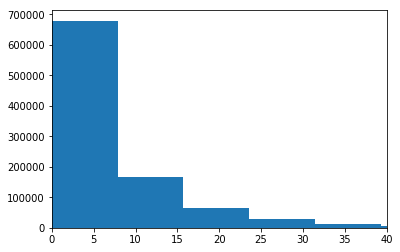

In [247]:
plt.hist(days, bins=50)
plt.xlim(0,40)
plt.show()

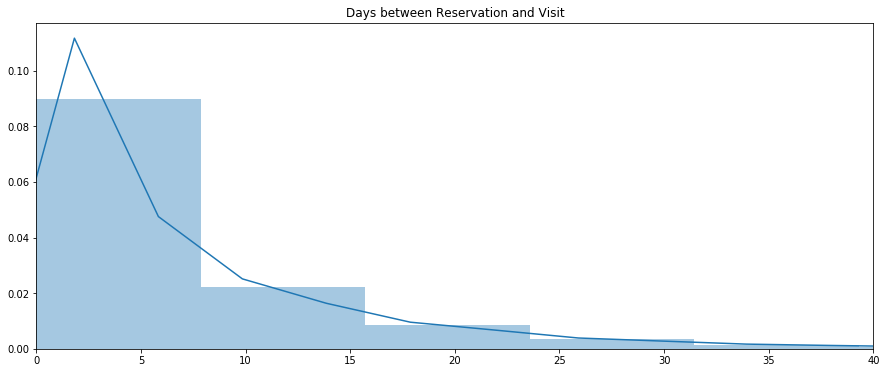

In [249]:
#
f,axa = plt.subplots(1,1,figsize=(15,6))
sns.distplot(days)
plt.xlim(0,40)
axa.set_title('Days between Reservation and Visit')
plt.show()

In [250]:
nf

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_genre_name,air_area_name,latitude,longitude,hpg_store_id,hpg_genre_name,hpg_area_name,cluster,vd,vt,rd,rt,visit_holiday,reservation_holiday
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,1,19:00:00,1,16:00:00,1,1
1,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,1,20:00:00,1,16:00:00,1,1
2,air_877f79706adbfb06,2016-01-02 18:00:00,2016-01-01 16:00:00,2,Japanese food,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,0,2,18:00:00,1,16:00:00,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963683,NaN,2017-04-24 19:00:00,2017-04-22 14:00:00,15,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None,0,114,19:00:00,112,14:00:00,0,0
963684,NaN,2017-04-24 19:00:00,2017-04-10 17:00:00,18,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None,0,114,19:00:00,100,17:00:00,0,0
963685,NaN,2017-04-28 18:00:00,2017-04-10 17:00:00,22,NaN,NaN,35.682504,139.773619,hpg_e106ddef2b137959,Japanese style,Tōkyō-to Chūō-ku None,0,118,18:00:00,100,17:00:00,0,0


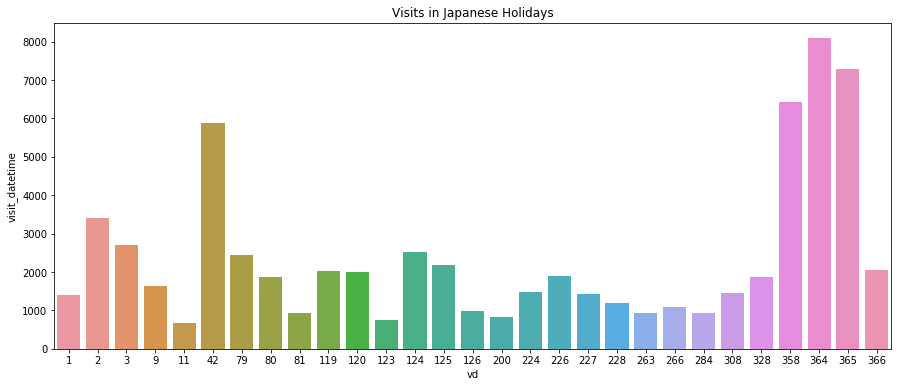

In [252]:
#
f,ax = plt.subplots(1,1, figsize=(15,6))
vholidayhist= nf[nf['visit_holiday']==1].groupby(['vd'], as_index=False).count()
sns.barplot(x = vholidayhist.vd, y=vholidayhist.visit_datetime)
ax.set_title('Visits in Japanese Holidays')
plt.show()

#1年間の祝日(29日間)にどのくらい客が来ているか

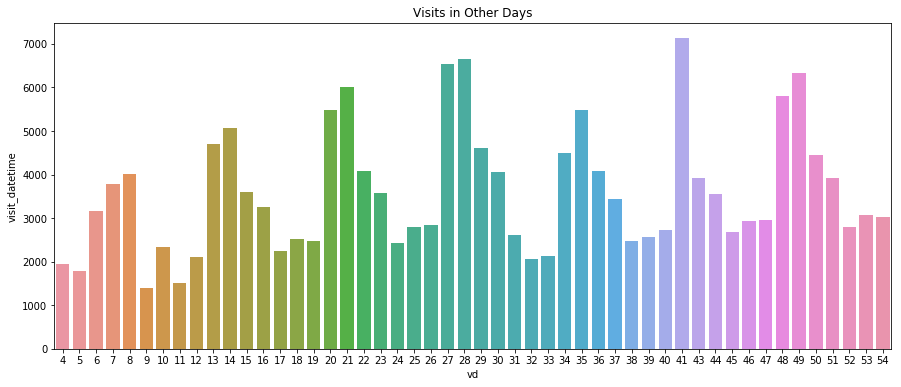

In [254]:
#
f,ax = plt.subplots(1,1, figsize=(15,6))
vholidayhist= nf[nf['visit_holiday']==0].groupby(['vd'],as_index=False).count()
sns.barplot(x = vholidayhist.vd[0:50],y=vholidayhist.visit_datetime)
ax.set_title('Visits in Other Days')
plt.show()

#祝日をのぞいた日にどのくらい客が来ているか

## Weather Data

In [255]:
#
wd = pd.read_csv('WeatherData.csv')
wd.head()

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1
3,fukuoka_dazaifu-kana_dasaif,1/4/16,0.0,9.4,NaN,NaN,4.2,1.8,NaN,NaN,NaN,NaN,NaN,NaN,16.1,5.9
4,fukuoka_dazaifu-kana_dasaif,1/5/16,1.5,8.8,NaN,NaN,0.0,0.8,NaN,NaN,NaN,NaN,NaN,NaN,12.3,7.1


In [288]:
#
import re
def area2group(area): # match は頭文字がそうなっているか検証するもの
    if re.match('tokyo', area) !=None: # r は基本つかなくてもいいが、バックスラッシュも認識してくれる
        return 0
    if re.match('osaka', area) !=None:
        return 1
    if re.match('hokkaido', area) !=None:
        return 2    
    if re.match('fukuoka', area) !=None:
        return 3
    if re.match('niigata', area) !=None:
        return 4
    if re.match('hiroshima', area) !=None:
        return 5
    if re.match('shizuoka', area) !=None:
        return 6
    if re.match('miyagi', area) !=None:
        return 7
    else:
        return -1

In [289]:
#
warea = [area2group(area) for area in wd.area_name]
wd['cluster'] = warea

In [294]:
wd.cluster.value_counts().sort_values(ascending=False)

-1    5170
 0    4653
 1    4136
      ... 
 6    3619
 5    1551
 7    1551
Name: cluster, Length: 9, dtype: int64

In [295]:
wd

,area_name,calendar_date,precipitation,avg_temperature,total_snowfall,deepest_snowfall,hours_sunlight,avg_wind_speed,avg_vapor_pressure,avg_humidity,avg_sea_pressure,avg_local_pressure,solar_radiation,cloud_cover,high_temperature,low_temperature,cluster
0,fukuoka_dazaifu-kana_dasaif,1/1/16,0.0,5.7,NaN,NaN,5.1,1.9,NaN,NaN,NaN,NaN,NaN,NaN,11.0,2.1,3
1,fukuoka_dazaifu-kana_dasaif,1/2/16,0.5,10.2,NaN,NaN,1.3,2.2,NaN,NaN,NaN,NaN,NaN,NaN,15.3,6.1,3
2,fukuoka_dazaifu-kana_dasaif,1/3/16,0.0,11.2,NaN,NaN,0.5,0.9,NaN,NaN,NaN,NaN,NaN,NaN,15.5,7.1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33085,yamaguchi__shimonoseki-kana__shimonoseki,5/29/17,NaN,23.2,NaN,NaN,12.8,3.7,15.2,55.0,1012.8,1010.6,26.96,0.0,27.7,19.2,-1
33086,yamaguchi__shimonoseki-kana__shimonoseki,5/30/17,NaN,23.6,NaN,NaN,12.1,2.4,18.4,64.0,1010.6,1008.4,25.24,6.3,28.8,19.4,-1
33087,yamaguchi__shimonoseki-kana__shimonoseki,5/31/17,0.0,23.0,NaN,NaN,3.1,1.5,20.4,73.0,1005.4,1003.1,14.75,8.5,26.5,20.9,-1


In [296]:
wd['calendar_date'] = pd.to_datetime(wd.calendar_date).dt.date

In [298]:
pd.to_datetime(nf.visit_datetime).dt.date

0         2016-01-01
1         2016-01-01
2         2016-01-02
             ...    
963683    2017-04-24
963684    2017-04-24
963685    2017-04-28
Name: visit_datetime, Length: 963686, dtype: object

In [300]:
nf['visit_date'] = pd.to_datetime(nf.visit_datetime).dt.date

In [303]:
wdg = wd.groupby(['cluster','calendar_date'],as_index=False).mean()
wnf = pd.merge(wdg, nf ,left_on=['cluster','calendar_date'], right_on=['cluster','visit_date'])

In [307]:
airvisit['visit_date'] = pd.to_datetime(airvisit['visit_date']).dt.date
wnf = pd.merge(wnf, airvisit, on=['air_store_id','visit_date'])

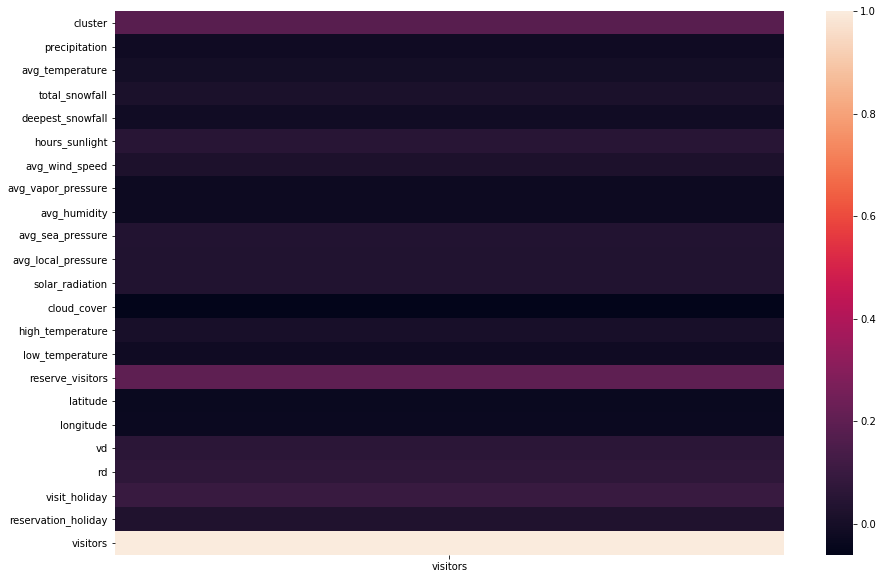

In [308]:
f,axa = plt.subplots(1,1,figsize=(15,10))
sns.heatmap(wnf.corr()[['visitors']])

Apparently there number of visitors is not correlated with the weather conditions